# Scraper
-----
- Extracts data from weather balloon readings
- Transforms data into standard format
- Displays data on easily understandable graphs

In [51]:
import requests
import pandas as pd
from datetime import date, datetime, timedelta
from bs4 import BeautifulSoup
import numpy as np
from math import floor
from pathlib import Path  
from alive_progress import alive_bar
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns

### Define baseline params
- URL to be used
- Columns to be extracted
- Weather stations to examine
- Current date/time

In [27]:
base_url = "http://weather.uwyo.edu/cgi-bin/sounding?region=naconf&TYPE=TEXT%3ALIST"

cols = ["Date", 
        "Station", 
        "Pressure", 
        "Height", 
        "Temp", 
        "DewPoint", 
        "Relative_Humidity", 
        "Mean_Mixed_Layer", 
        "Wind_Direction", 
        "Wind_Speed", 
        "Potential_Temp",
        "Equivalent_Potential_Temp",
        "Virtual_Potential_Temp"]

stations = [
    {"id": 72797, "name": "Quillayute"},
    {"id": 73033, "name": "Vernon"},
    {"id": 71109, "name": "Port Hardy"}]

now = [
    datetime.now().year, 
    datetime.now().month, 
    datetime.now().day]

## Define date range function
---
- Accept start and end date
- Return range of dates between start and end

In [28]:
# Creates date range from str format dates
# e.g. "2021-01-01"
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

## Create list of URLs to scrape
---
- Iterate throguh date ranges
- Iterate through stations
- Return list of all URLs to be scraped

In [81]:
# Create date range
# ~~~~~~~~~~~~~~~~~
dates_arr = []
start_date = date(2022, 10, 1)
#start_date = date(now[0], now[1], now[2])
end_date = date(now[0], now[1], now[2]+1)
print(f"Start Date:\t{start_date}\nEnd Date:\t{end_date}")

for single_date in daterange(start_date, end_date):
    single_date = (str(single_date).split("-")) 
    dates_arr.append([ int(x) for x in single_date ])
       
# Create list of URLs for each station
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
urls = []
dates_idx = []
station_idx = []
for d in dates_arr:
    for station in stations:
        url = base_url
        url += "&YEAR={}".format(d[0])
        url += "&MONTH={}".format(d[1])
        #url += "&FROM=" + str(now[1]) + str(now[2])
        #url += "&TO=" + str(now[1]) + str(now[2])
        url += "&FROM={:0>2d}12".format(d[2])
        url += "&TO={:0>2d}12".format(d[2])
        url += "&STNM={}".format(station["id"])
        url += "&REPLOT=1"
        urls.append(url)
        
        
        dates_idx.append("%02d-%02d-%02d" % (d[0], d[1], d[2]))
        station_idx.append(station["name"])

print(urls[0])
for url in urls:
    print(url)

Start Date:	2022-10-01
End Date:	2022-12-07
http://weather.uwyo.edu/cgi-bin/sounding?region=naconf&TYPE=TEXT%3ALIST&YEAR=2022&MONTH=10&FROM=0112&TO=0112&STNM=72797&REPLOT=1
http://weather.uwyo.edu/cgi-bin/sounding?region=naconf&TYPE=TEXT%3ALIST&YEAR=2022&MONTH=10&FROM=0112&TO=0112&STNM=72797&REPLOT=1
http://weather.uwyo.edu/cgi-bin/sounding?region=naconf&TYPE=TEXT%3ALIST&YEAR=2022&MONTH=10&FROM=0112&TO=0112&STNM=73033&REPLOT=1
http://weather.uwyo.edu/cgi-bin/sounding?region=naconf&TYPE=TEXT%3ALIST&YEAR=2022&MONTH=10&FROM=0112&TO=0112&STNM=71109&REPLOT=1
http://weather.uwyo.edu/cgi-bin/sounding?region=naconf&TYPE=TEXT%3ALIST&YEAR=2022&MONTH=10&FROM=0212&TO=0212&STNM=72797&REPLOT=1
http://weather.uwyo.edu/cgi-bin/sounding?region=naconf&TYPE=TEXT%3ALIST&YEAR=2022&MONTH=10&FROM=0212&TO=0212&STNM=73033&REPLOT=1
http://weather.uwyo.edu/cgi-bin/sounding?region=naconf&TYPE=TEXT%3ALIST&YEAR=2022&MONTH=10&FROM=0212&TO=0212&STNM=71109&REPLOT=1
http://weather.uwyo.edu/cgi-bin/sounding?region=nacon

## Extract data from list of URLs
---
- Iterate through URLs
- Extract 700 and 850 data items
- Append data to array

In [82]:
data = []
reading_idx = []


print("Extracting data from URLs: ")
with alive_bar(len(urls), force_tty=True) as bar:
    for i, url in enumerate(urls):
        
        # scrape site data
        # ~~~~~~~~~~~~~~~~
        page = requests.get(url)
        soup = BeautifulSoup(page.content, "html.parser")
        results = str(soup.find('pre'))

        # we want 700 first // 850 second
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        data.append(results[results.find("700"):].split()[:11])
        data[-1].insert(0, dates_idx[i])
        data[-1].insert(1, station_idx[i])
        data.append(results[results.find("850"):].split()[:11])
        data[-1].insert(0, dates_idx[i])
        data[-1].insert(1, station_idx[i])
        
        bar()
        

print("\nComplete")


Extracting data from URLs: 
|████████████████████████████████████████| 201/201 [100%] in 6:41.4 (0.50/s)                                            

Complete


## Clean Data
---
- Remove unwanted chars from fields
- Convert wind speed to km/h from knots

In [88]:
# Remove rogue "e" values from pressure field
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
pressures = [700, 850]
ctr = 0
for item in data:
    if(not str(item[2]).isnumeric()):
        item[2] = pressures[ctr%2]
    ctr += 1

In [91]:
df = pd.DataFrame(data, columns=cols)

# Convert DataFrame to numeric values
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for col in cols[2:]:
    try:
        df[col] = pd.to_numeric(df[col])
    except:
        print(col)
    
# Convert wind speed from Knots to KM/H
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
df['Wind_Speed'] = df['Wind_Speed'].multiply(1.852)
df.head()

,Date,Station,Pressure,Height,Temp,DewPoint,Relative_Humidity,Mean_Mixed_Layer,Wind_Direction,Wind_Speed,Potential_Temp,Equivalent_Potential_Temp,Virtual_Potential_Temp
0,2022-10-01,Quillayute,700,3156.0,5.6,-5.4,45.0,3.67,45.0,20.372,308.6,320.4,309.3
1,2022-10-01,Quillayute,850,1541.0,14.4,5.4,55.0,6.66,155.0,12.964,301.2,321.3,302.4
2,2022-10-01,Vernon,700,3153.0,3.2,-3.8,60.0,4.14,200.0,14.816,306.0,319.0,306.8
3,2022-10-01,Vernon,850,1545.0,12.4,7.4,72.0,7.65,60.0,9.260,299.1,321.9,300.5
4,2022-10-01,Port Hardy,700,3174.0,5.2,-4.8,48.0,3.84,260.0,16.668,308.2,320.5,308.9


In [92]:
df.tail()

,Date,Station,Pressure,Height,Temp,DewPoint,Relative_Humidity,Mean_Mixed_Layer,Wind_Direction,Wind_Speed,Potential_Temp,Equivalent_Potential_Temp,Virtual_Potential_Temp
397,2022-12-06,Quillayute,850,1455.0,-4.7,-5.1,97.0,3.09,260.0,25.928,281.2,290.1,281.7
398,2022-12-06,Vernon,700,2897.0,-11.7,-13.6,86.0,1.92,300.0,64.820,289.5,295.4,289.8
399,2022-12-06,Vernon,850,1395.0,-8.3,-10.0,88.0,2.11,220.0,38.892,277.4,283.6,277.8
400,2022-12-06,Port Hardy,700,2969.0,-7.3,-14.3,57.0,1.81,310.0,53.708,294.4,300.1,294.7
401,2022-12-06,Port Hardy,850,1430.0,-4.7,-6.5,87.0,2.78,260.0,25.928,281.2,289.2,281.7


## Export data to CSV
---
Create new file for each date the extraction is run and save to /data/ folder

In [93]:
filepath = Path('./data/raw_scrape-{}-{}-{}.csv'.format(datetime.now().year, datetime.now().month, datetime.now().day))  
filepath.parent.mkdir(parents=True, exist_ok=True) 
df.to_csv(filepath)

### Split Data by Region
---
Seperate the general DataFrame for simpler manipulation

In [94]:
quillayute = df[df['Station'] == "Quillayute"]
vernon = df[df['Station'] == "Vernon"]
port_hardy = df[df['Station'] == "Port Hardy"]

df.set_index(['Date','Station','Pressure'])

Height  Temp  DewPoint  Relative_Humidity  \
Date       Station    Pressure                                              
2022-10-01 Quillayute 700       3156.0   5.6      -5.4               45.0   
                      850       1541.0  14.4       5.4               55.0   
           Vernon     700       3153.0   3.2      -3.8               60.0   
                      850       1545.0  12.4       7.4               72.0   
           Port Hardy 700       3174.0   5.2      -4.8               48.0   
...                                ...   ...       ...                ...   
2022-12-06 Quillayute 850       1455.0  -4.7      -5.1               97.0   
           Vernon     700       2897.0 -11.7     -13.6               86.0   
                      850       1395.0  -8.3     -10.0               88.0   
           Port Hardy 700       2969.0  -7.3     -14.3               57.0   
                      850       1430.0  -4.7      -6.5               87.0   

                                Mean_Mixed_Layer  Wind_Direction  Wind_Speed  \
Date       Station    Pressure                                                 
2022-10-01 Quillayute 700                   3.67            45.0      20.372   
                      850                   6.66           155.0      12.964   
           Vernon     700                   4.14           200.0      14.816   
                      850                   7.65            60.0       9.260   
           Port Hardy 700                   3.84           260.0      16.668   
...                                          ...             ...         ...   
2022-12-06 Quillayute 850                   3.09           260.0      25.928   
           Vernon     700                   1.92           300.0      64.820   
                      850                   2.11           220.0      38.892   
           Port Hardy 700                   1.81           310.0      53.708   
                      850                   2.78           260.0      25.928   

                                Potential_Temp  Equivalent_Potential_Temp  \
Date       Station    Pressure                                              
2022-10-01 Quillayute 700                308.6                      320.4   
                      850                301.2                      321.3   
           Vernon     700                306.0                      319.0   
                      850                299.1                      321.9   
           Port Hardy 700                308.2                      320.5   
...                                        ...                        ...   
2022-12-06 Quillayute 850                281.2                      290.1   
           Vernon     700                289.5                      295.4   
                      850                277.4                      283.6   
           Port Hardy 700                294.4                      300.1   
                      850                281.2                      289.2   

                                Virtual_Potential_Temp  
Date       Station    Pressure                          
2022-10-01 Quillayute 700                        309.3  
                      850                        302.4  
           Vernon     700                        306.8  
                      850                        300.5  
           Port Hardy 700                        308.9  
...                                                ...  
2022-12-06 Quillayute 850                        281.7  
           Vernon     700                        289.8  
                      850                        277.8  
           Port Hardy 700                        294.7  
                      850                        281.7  

[402 rows x 10 columns]

## Plot Data
---

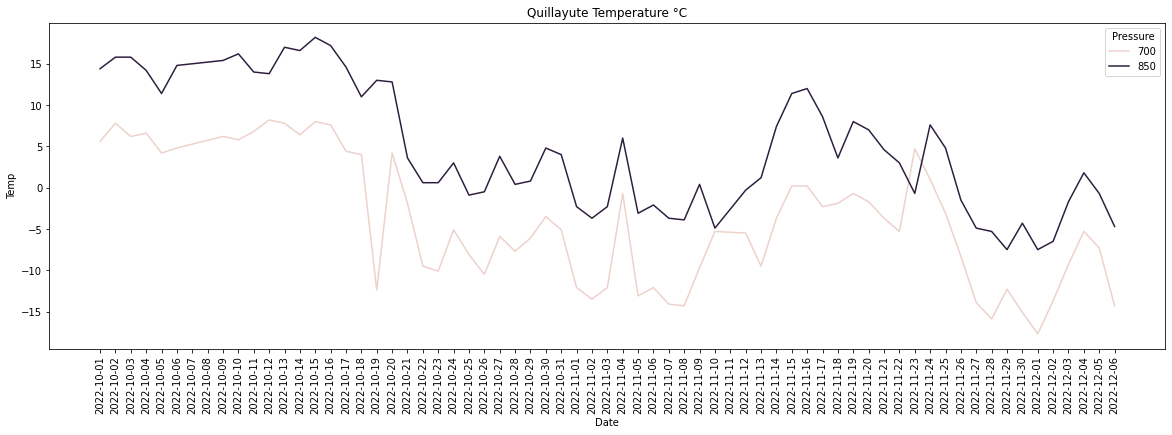

In [98]:
# Line chart showing the number of visitors to each museum over time
# Set the width and height of the figure
plt.figure(figsize=(20,6))

# Add title
plt.title("Quillayute Temperature °C")

# Line chart showing daily global streams of each song 
sns.lineplot(x='Date', y='Temp', hue='Pressure', 
             data=df[df['Station'] == "Quillayute"])

plt.xticks(rotation = 'vertical')


plt.show()

In [ ]:
# Line chart showing the number of visitors to each museum over time
# Set the width and height of the figure
plt.figure(figsize=(14,6))

# Add title
plt.title("Quillayute Temperature °C")

# Line chart showing daily global streams of each song 
sns.lineplot(data=quillayute['Temp'], label="700")

sns.lineplot(data=vernon['Temp'], label="Vernon", hue="Pressure")
sns.lineplot(data=port_hardy['Temp'], label="Port Hardy", hue="Pressure")

plt.show()

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
#  ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ NOTES ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

## APP (2)

Easy to read / on the go / big text

700 | 3020m | -7 |
- - - - - - - - -
850 | 1590m | -9 |

Wind direction in an arrow // color coded magnitude and direction


Gathering data from brohm ridge needs to be done hourly
- looking like avalanche canada page on Wx


## Drive (1)
Guide daily forms
- Integrate to slack

Users need to see
- Just the weather info


## Webcms (3)
(load one by one -- javascript)
- cayoosh
- whistler peak
- blackcomb
- rubble creek
- brohm ridge
- s2s


western developement fund of canada /// Western Economic Diversification Canada

In [ ]:
table = [dates]
dates = [locations]
location = [variables]